# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
 -1
 -1
  1
 -1
 -1
  1
  1
  1
  ⋮
  1
 -1
 -1
  1
 -1
  1
  1
 -1
 -1

### We create a function to visualize the data

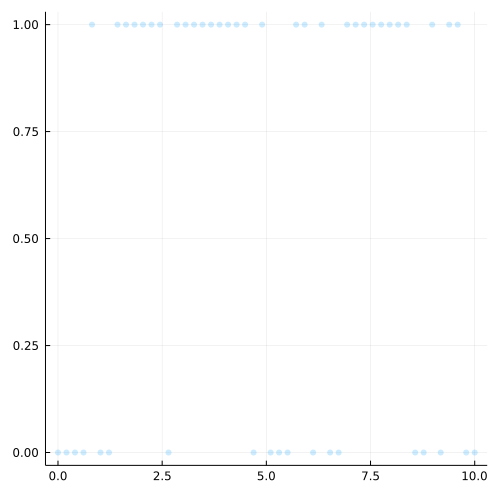

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.028156 seconds (1.82 M allocations: 103.690 MiB, 7.77% gc time, 99.55% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink()) infered by Analytic Variational Inference , (local_vars = (c = [1.1651458856019257, 1.114508509540454, 1.0214434301629314, 0.8921498468363086, 0.7481520014709289, 0.6337925856588446, 0.6093854146616853, 0.6959119742382784, 0.8477949741154256, 1.0140252448836145  …  1.043367939477378, 0.9223889137888471, 0.7981235801352108, 0.694185501762254, 0.6293623995062522, 0.6102719039625274, 0.6292309803820679, 0.6717963071106604, 0.7255278610394227, 0.7820461565726876], θ = [0.22509326473765737, 0.226977792481966, 0.2303149247818062, 0.23463953607014154, 0.2389566504315803, 0.24195442620430868, 0.24254041950576888, 0.24037635229672477, 0.23602921651130093, 0.2305733097635394  …  0.22954445911761326, 0.2336634904986373, 0.23752330895454826, 0.24042185315609682, 0.24206224312589592, 0.24251947958627132, 0.24206543167128391, 0.24100350647933358, 0.2395816007151262, 0.23799226979852586]

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:41
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:53
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:55
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:26
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:08
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:57
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:42
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:28
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-1.052093200528008, -0.9844255198023286, -0.9049152863196943, -0.8310709720513013, -0.7749907363954289, -0.7377354700840915, -0.6604335569946135, -0.5141396260627131, -0.31544634602367927, -0.09349821093502841  …  1.188256047950848, 1.038139048906562, 0.8213334486399975, 0.5647975390702353, 0.2879620611207044, 0.016681582397716055, -0.25349742607381043, -0.4903603493942992, -0.6805643650314185, -0.8206282139808649]]
 [[-1.2078583505806666, -1.321810507816269, -1.327816920029178, -1.1809689411914928, -0.952846852705383, -0.6788933645415796, -0.40753476837402436, -0.14158666239275125, 0.12097204885737228, 0.3431623804957157  …  0.7445446222563706, 0.7410855086289042, 0.6140161237539853, 0.39402055460036245, 0.10831892106890283, -0.26859127273754446, -0.6001723621302122, -0.8290560697225561, -0.9637484813774888, -0.9967957472203223]]
 [[-0.15183657593745903, -0.11377938450865777, -0.08697932417316856, -0.1210455368374832, -0.128629222785772

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

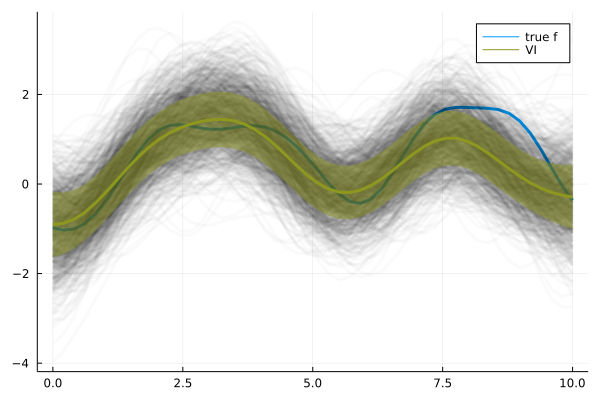

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

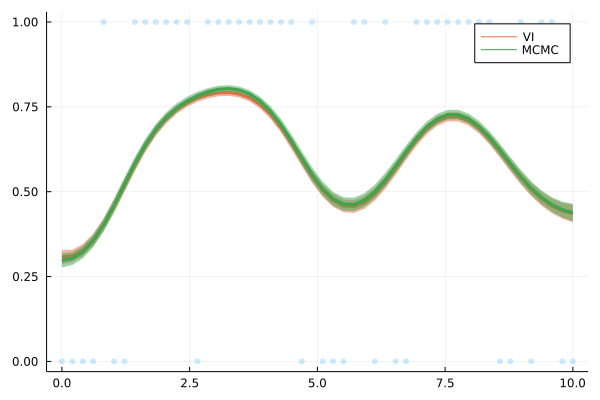

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*